In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from auxiliary import plot_boundary, plot_svm_margins

sns.set()

# Support Vector Machines
## Clasificación

Para arrancar con el modelo SVM como clasificador (SVC), vamos a arrancar con datos sintéticos. Usamos un caso que no es linealmente separable

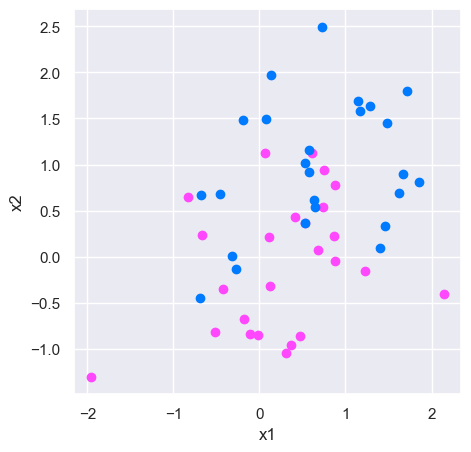

In [2]:
rng = np.random.default_rng(seed=42)

X = rng.standard_normal((50, 2)) 
y = np.array([-1]*25+[1]*25)
# Sumamos uno a la clase azul para desplazarlo 
X[y==1] += 1

fig, ax = plt.subplots(figsize=(5,5)) 
ax.scatter(X[:25,0], X[:25,1], c="#ff48fd")
ax.scatter(X[25:,0], X[25:,1], c="#007aff")
ax.set_xlabel("x1")
ax.set_ylabel("x2");

Creamos un modelo SVC usando [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), definimos el caso lineal con C=10

In [3]:
from sklearn.svm import SVC

In [4]:
svm_linear = SVC(C=10, kernel='linear')
svm_linear.fit(X, y)

SVC(C=10, kernel='linear')

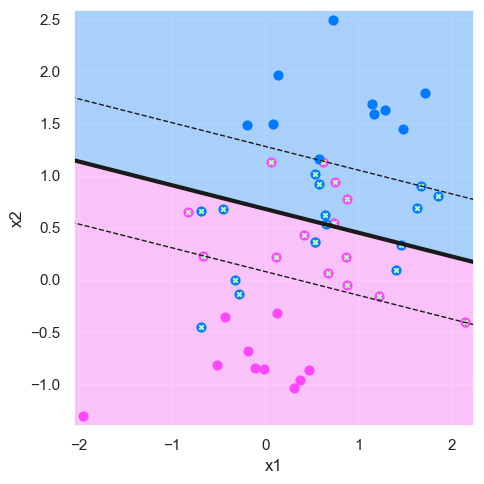

In [5]:
plot_boundary(X, y, svm_linear, 
              step_x=(0.01, 0.01),
              max_x=(0.1, 0.1),
              min_x=(-0.1, -0.1),
              colormap_frontier=('#ffb7fe', '#93c7ff'),
              colormap_points=('#ff48fd', '#007aff'),
              figsize=(5, 5),
              legend=False,
              point_size=40)
# Grafiquemos los vectores de soporte
plt.scatter(svm_linear.support_vectors_[:,0], svm_linear.support_vectors_[:,1], marker="x", color="#b8ffb7", s=10);

# Graficamos los bordes de decision
plot_svm_margins(X, svm_linear)

plt.tight_layout();

Veamos entrenar el modelo con un parámetro mas chico C=0.1

In [6]:
svm_linear_small = SVC(C=0.1, kernel='linear')
svm_linear_small.fit(X, y)

SVC(C=0.1, kernel='linear')

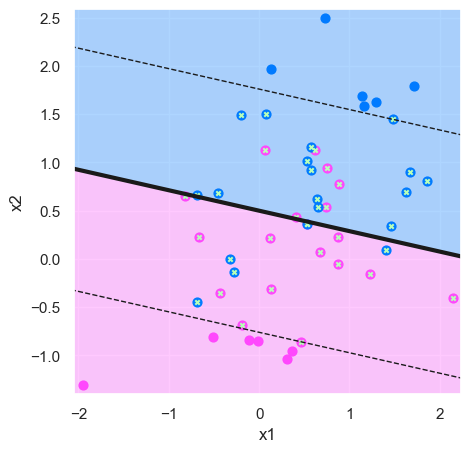

In [7]:
plot_boundary(X, y, svm_linear_small, 
              step_x=(0.01, 0.01),
              max_x=(0.1, 0.1),
              min_x=(-0.1, -0.1),
              colormap_frontier=('#ffb7fe', '#93c7ff'),
              colormap_points=('#ff48fd', '#007aff'),
              figsize=(5, 5),
              legend=False,
              point_size=40)
# Grafiquemos los vectores de soporte
plt.scatter(svm_linear_small.support_vectors_[:,0], svm_linear_small.support_vectors_[:,1], marker="x", color="#b8ffb7", s=10);

# Graficamos los bordes de decision
plot_svm_margins(X, svm_linear_small)

Con SVC lineales podemos obtener los coeficientes de la recta de decisión:

In [8]:
svm_linear.coef_

array([[0.37943953, 1.66730076]])

Aprovechemos este caso sencillo para hacer una optimización del hiperparámetro C usando [Grid Search](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)

In [9]:
from sklearn.model_selection import GridSearchCV

svm_linear = SVC(kernel='linear')

grid = GridSearchCV(svm_linear,
                    {"C": [0.001, 0.01, 0.1, 1, 5, 10, 100]},
                    refit=True,
                    cv=5,
                    scoring='accuracy')
grid.fit(X,y)

GridSearchCV(cv=5, estimator=SVC(kernel='linear'),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 5, 10, 100]},
             scoring='accuracy')

Vemos que el mejor valor es cuando C=0.1

In [10]:
grid.best_params_

{'C': 0.1}

Podemos chusmear las metricas para cada caso:

In [11]:
grid.cv_results_['mean_test_score']

array([0.7 , 0.7 , 0.76, 0.74, 0.68, 0.68, 0.7 ])

In [12]:
grid.cv_results_['std_test_score']

array([0.08944272, 0.08944272, 0.10198039, 0.10198039, 0.04      ,
       0.04      , 0.06324555])

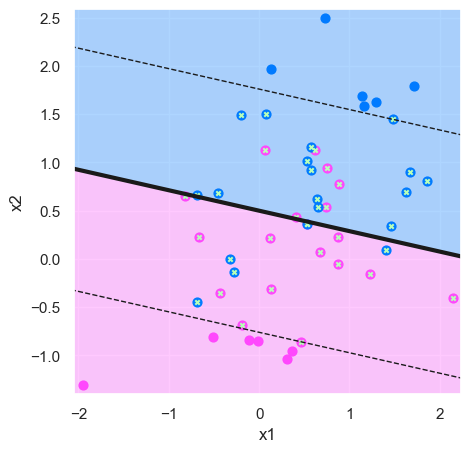

In [13]:
# No necesitamos entrenar el modelo porque con el parámetro refit de GridSearchCV ya lo entrenó por nosotros
svm_best = grid.best_estimator_

plot_boundary(X, y, svm_best, 
              step_x=(0.01, 0.01),
              max_x=(0.1, 0.1),
              min_x=(-0.1, -0.1),
              colormap_frontier=('#ffb7fe', '#93c7ff'),
              colormap_points=('#ff48fd', '#007aff'),
              figsize=(5, 5),
              legend=False,
              point_size=40)
# Grafiquemos los vectores de soporte
plt.scatter(svm_best.support_vectors_[:,0], svm_best.support_vectors_[:,1], marker="x", color="#b8ffb7", s=10);

# Graficamos los bordes de decision
plot_svm_margins(X, svm_best)

Con esto podemos predecir la clase de un set de testeo

In [14]:
X_test = rng.standard_normal((20, 2)) 
y_test = np.array([-1]*10+[1]*10) 
X_test[y_test==1] += 1

y_pred = svm_best.predict(X_test)

Evaluamos usando la matriz de confusión

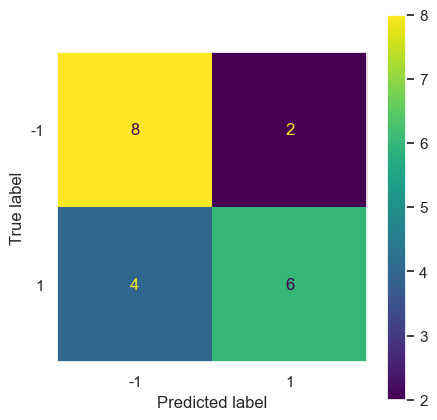

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=svm_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_best.classes_)

fig, ax = plt.subplots(figsize=(5,5))
ax.grid(False)
disp.plot(ax=ax);

In [16]:
from sklearn.metrics import accuracy_score

print(f"El porcentaje de exactitud es de:{accuracy_score(y_test, y_pred)*100: .0f}%")

El porcentaje de exactitud es de: 70%


---

Veamos un caso que es linealmente separable

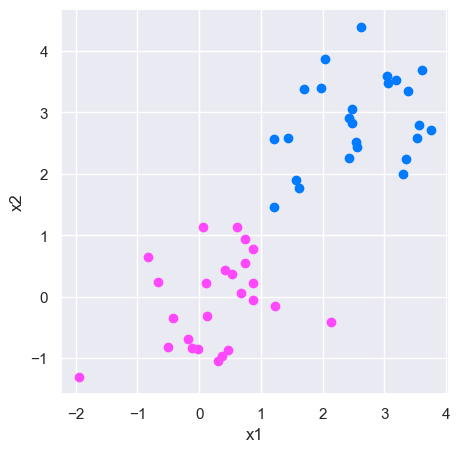

In [17]:
#Tomamos el caso sintentico anterior pero lo separamos mas
Xsep = X.copy()
Xsep[y==1] += 1.9

fig, ax = plt.subplots(figsize=(5,5)) 
ax.scatter(Xsep[:25,0], Xsep[:25,1], c="#ff48fd")
ax.scatter(Xsep[25:,0], Xsep[25:,1], c="#007aff")
ax.set_xlabel("x1")
ax.set_ylabel("x2");

Estamos en el caso de un modelo **Maximal Margin Classifier**, por lo que usamos un valor de C muy grande:

In [18]:
svm_separable = SVC(C=1e5, kernel='linear')
svm_separable.fit(Xsep, y)

SVC(C=100000.0, kernel='linear')

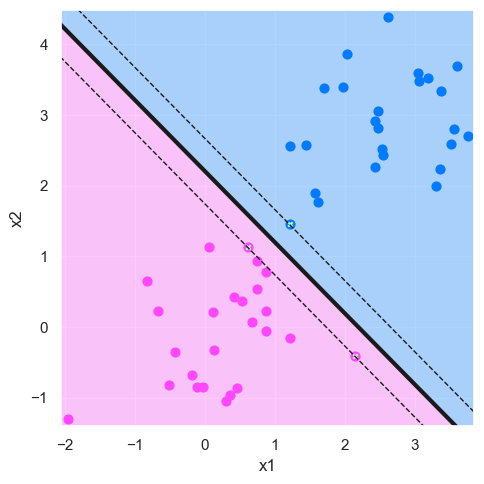

In [19]:
plot_boundary(Xsep, y, svm_separable, 
              step_x=(0.01, 0.01),
              max_x=(0.1, 0.1),
              min_x=(-0.1, -0.1),
              colormap_frontier=('#ffb7fe', '#93c7ff'),
              colormap_points=('#ff48fd', '#007aff'),
              figsize=(5, 5),
              legend=False,
              point_size=40)


# Grafiquemos los vectores de soporte
plt.scatter(svm_separable.support_vectors_[:,0], svm_separable.support_vectors_[:,1], marker="x", color="#b8ffb7", s=10);

# Graficamos los bordes de decision
plot_svm_margins(Xsep, svm_separable)

plt.tight_layout();

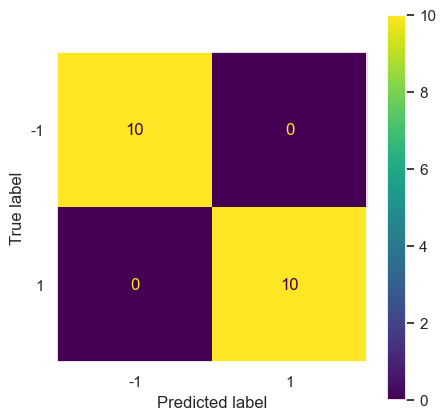

In [20]:
X_test[y_test==1] += 1.9
y_pred = svm_separable.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=svm_separable.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_best.classes_)

fig, ax = plt.subplots(figsize=(5,5))
ax.grid(False)
disp.plot(ax=ax);

## Uso de funciones Kernels

Veamos ahora cuando clasificamos con un modelo con una frontera de decision no lineal usando una funcion kernel. 

Empezamos con la función kernel polinomica, que tenemos como hiperparámetro, además de la C, el orden del polinomio, que en [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.decision_function) se pasa como  el argumento **gamma**. 

Pero, vamos a realizar primero una busqueda de posibles hiperparametro, tanto para C como para gamma usando **gridsearchCV**

In [21]:
svm_poly = SVC(kernel='poly')

grid = GridSearchCV(svm_poly,
                    {'C': [1, 5, 10], 'degree': [2, 3, 4, 5]},
                    refit=True,
                    cv=5,
                    scoring='accuracy')
grid.fit(X, y)

GridSearchCV(cv=5, estimator=SVC(kernel='poly'),
             param_grid={'C': [1, 5, 10], 'degree': [2, 3, 4, 5]},
             scoring='accuracy')

In [22]:
# Vemos todos los datos de la busqueda como Dataframe que nos facilita la visualizacion
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000672,0.000236,0.000386,0.000078,1,2,"{'C': 1, 'degree': 2}",0.6,0.6,0.9,0.5,0.6,0.64,0.135647,9
1,0.000298,0.000011,0.000266,0.000020,1,3,"{'C': 1, 'degree': 3}",0.7,0.8,0.8,0.7,0.6,0.72,0.074833,3
2,0.000302,0.000021,0.000250,0.000023,1,4,"{'C': 1, 'degree': 4}",0.6,0.8,0.8,0.6,0.6,0.68,0.097980,6
3,0.000295,0.000030,0.000245,0.000017,1,5,"{'C': 1, 'degree': 5}",0.7,0.8,0.8,0.7,0.7,0.74,0.048990,1
4,0.000294,0.000009,0.000238,0.000006,5,2,"{'C': 5, 'degree': 2}",0.6,0.6,0.9,0.5,0.6,0.64,0.135647,9
5,0.000276,0.000009,0.000261,0.000062,5,3,"{'C': 5, 'degree': 3}",0.7,0.6,0.8,0.7,0.7,0.70,0.063246,4
6,0.000422,0.000084,0.000316,0.000077,5,4,"{'C': 5, 'degree': 4}",0.6,0.7,0.8,0.6,0.6,0.66,0.080000,8
7,0.000360,0.000065,0.000261,0.000028,5,5,"{'C': 5, 'degree': 5}",0.8,0.7,0.8,0.5,0.6,0.68,0.116619,7
8,0.000301,0.000014,0.000231,0.000002,10,2,"{'C': 10, 'degree': 2}",0.6,0.6,0.9,0.5,0.6,0.64,0.135647,9
9,0.000292,0.000015,0.000228,0.000002,10,3,"{'C': 10, 'degree': 3}",0.7,0.6,0.8,0.7,0.7,0.70,0.063246,4


In [23]:
grid.best_params_

{'C': 1, 'degree': 5}

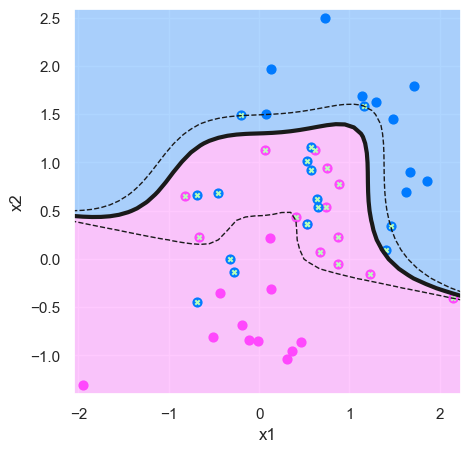

In [24]:
svm_poly_best = grid.best_estimator_

plot_boundary(X, y, svm_poly_best, 
              step_x=(0.01, 0.01),
              max_x=(0.1, 0.1),
              min_x=(-0.1, -0.1),
              colormap_frontier=('#ffb7fe', '#93c7ff'),
              colormap_points=('#ff48fd', '#007aff'),
              figsize=(5, 5),
              legend=False,
              point_size=40)
# Grafiquemos los vectores de soporte
plt.scatter(svm_poly_best.support_vectors_[:,0], svm_poly_best.support_vectors_[:,1], marker="x", color="#b8ffb7", s=10);

# Graficamos los bordes de decision
plot_svm_margins(X, svm_poly_best)

Otro tipo de función de kernel que vimos es la radial, habiamos visto en clase que teniamos el hiperparámetro gamma. Si usamos esta función en [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.decision_function), podemos pasar el argumento como **gamma**, al igual que el caso de kernel polinomial.

Para probar este kernel vamos a usar otro dataset sintético

In [25]:
from sklearn.model_selection import train_test_split

X = rng.standard_normal((200, 2)) 
X[:100] += 2
X[100:150] -= 2
y = np.array([1]*150+[2]*50)

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.5, random_state=0)

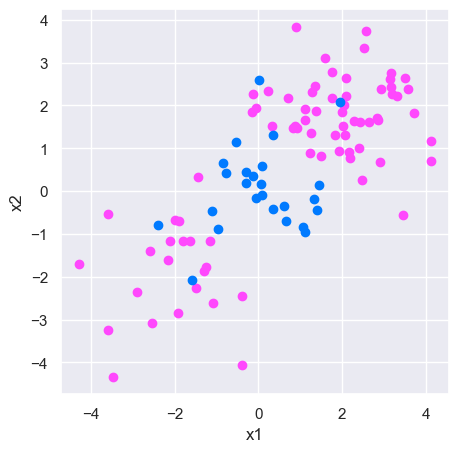

In [26]:
fig, ax = plt.subplots(figsize=(5,5)) 
ax.scatter(X_train[y_train==1][:,0], X_train[y_train==1][:,1], c="#ff48fd")
ax.scatter(X_train[y_train==2][:,0], X_train[y_train==2][:,1], c="#007aff")
ax.set_xlabel("x1")
ax.set_ylabel("x2");

Pero, vamos a realizar primero una busqueda de posibles hiperparametro, tanto para C como para gamma usando **gridsearchCV**

In [27]:
svm_kbf = SVC(kernel='rbf')

grid = GridSearchCV(svm_kbf,
                    {"C": [0.001, 0.01, 0.1, 1, 5, 10, 100],
                     "gamma": [0.5, 1, 2, 3, 4]},
                    refit=True,
                    cv=5,
                    scoring='accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 5, 10, 100],
                         'gamma': [0.5, 1, 2, 3, 4]},
             scoring='accuracy')

In [28]:
grid.best_params_

{'C': 1, 'gamma': 2}

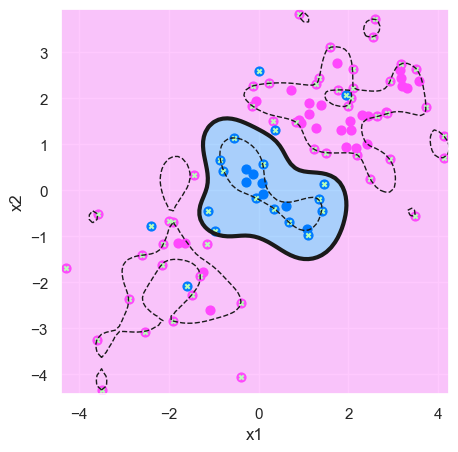

In [29]:
svm_rbf_best = grid.best_estimator_

plot_boundary(X_train, y_train, svm_rbf_best, 
              step_x=(0.01, 0.01),
              max_x=(0.1, 0.1),
              min_x=(-0.1, -0.1),
              colormap_frontier=('#ffb7fe', '#93c7ff'),
              colormap_points=('#ff48fd', '#007aff'),
              figsize=(5, 5),
              legend=False,
              point_size=40)
# Grafiquemos los vectores de soporte
plt.scatter(svm_rbf_best.support_vectors_[:,0], svm_rbf_best.support_vectors_[:,1], marker="x", color="#b8ffb7", s=10);

# Graficamos los bordes de decision
plot_svm_margins(X_train, svm_rbf_best)

Podemos evaluar el modelo con un set de testeo

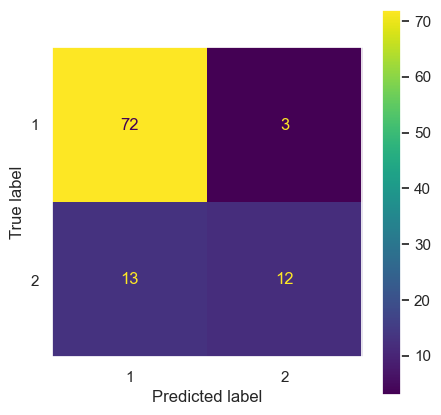

In [30]:
y_pred = svm_rbf_best.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=svm_rbf_best.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_rbf_best.classes_)

fig, ax = plt.subplots(figsize=(5,5))
ax.grid(False)
disp.plot(ax=ax);

In [31]:
print(f"El porcentaje de exactitud es de:{accuracy_score(y_test, y_pred)*100: .0f}%")

El porcentaje de exactitud es de: 84%


----

## Clasificación de multi-clase con SVM

El modelo [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.decision_function) implementado por sklearn nos permite realizar clasificacion de multiclase en cualquier de los dos clases que vimos en clase. Para ello tenemos el atributo *decision_function_shape* que puede tomar dos formas:

- 'ovo': Estrategia One vs one
- 'ovr': Estrategia One vs rest (One vs all).

Creemos una data sintetica para este caso:

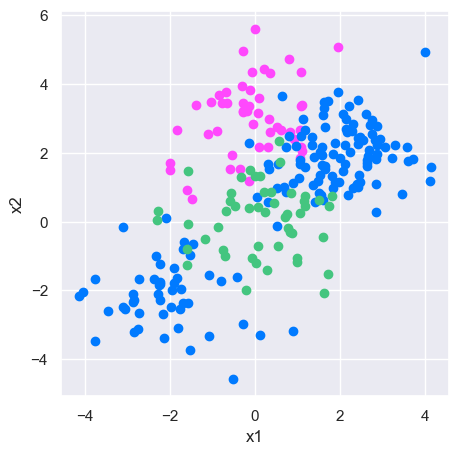

In [32]:
rng = np.random.default_rng(42)

X = rng.standard_normal((200, 2)) 
X[:100] += 2
X[100:150] -= 2
y = np.array([1]*150+[2]*50)

X = np.vstack([X, rng.standard_normal((50, 2))]) 
y = np.hstack([y, [0]*50])
X[y==0,1] += 3

fig, ax = plt.subplots(figsize=(5,5)) 
ax.scatter(X[y==0][:,0], X[y==0][:,1], c="#ff48fd")
ax.scatter(X[y==1][:,0], X[y==1][:,1], c="#007aff")
ax.scatter(X[y==2][:,0], X[y==2][:,1], c="#44c57f")
ax.set_xlabel("x1")
ax.set_ylabel("x2");

Entrenamos el modelo con un kernel RBF y una estrategia one-vs-one

In [33]:
svm_rbf_3 = SVC(kernel="rbf", C=1, gamma=0.1, decision_function_shape='ovo'); 
svm_rbf_3.fit(X, y)

SVC(C=1, decision_function_shape='ovo', gamma=0.1)

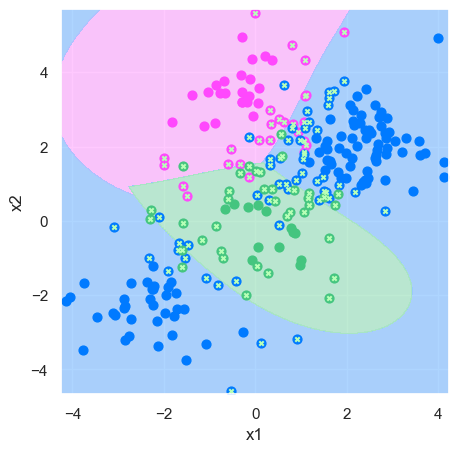

In [34]:
plot_boundary(X, y, svm_rbf_3, 
              step_x=(0.01, 0.01),
              max_x=(0.1, 0.1),
              min_x=(-0.1, -0.1),
              colormap_frontier=('#ffb7fe', '#93c7ff', "#a9e5c5"),
              colormap_points=('#ff48fd', '#007aff', "#44c57f"),
              label_point=(0, 1, 2),
              figsize=(5, 5),
              legend=False,
              point_size=40)

# Grafiquemos los vectores de soporte
plt.scatter(svm_rbf_3.support_vectors_[:,0], svm_rbf_3.support_vectors_[:,1], marker="x", color="#b8ffb7", s=10);

Para entender como se arman las zonas de decisión, veamos las fronteras de decisión:

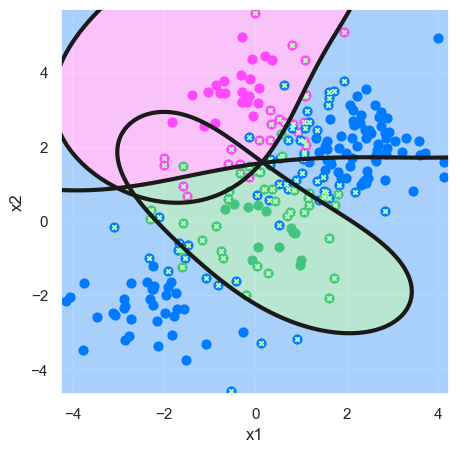

In [35]:
plot_boundary(X, y, svm_rbf_3, 
              step_x=(0.01, 0.01),
              max_x=(0.1, 0.1),
              min_x=(-0.1, -0.1),
              colormap_frontier=('#ffb7fe', '#93c7ff', "#a9e5c5"),
              colormap_points=('#ff48fd', '#007aff', "#44c57f"),
              label_point=(0, 1, 2),
              figsize=(5, 5),
              legend=False,
              point_size=40)

# Grafiquemos los vectores de soporte
plt.scatter(svm_rbf_3.support_vectors_[:,0], svm_rbf_3.support_vectors_[:,1], marker="x", color="#b8ffb7", s=10);

# Graficamos los bordes de decision
plot_svm_margins(X, svm_rbf_3, linewidths=[0, 3, 0])

----

## SVC en Heart

Para practicar con un dataset real usemos el dataset [**Heart**](https://archive.ics.uci.edu/dataset/45/heart+disease), el cual mediciones de 1025 pacientes, con 13 atributos de variables fisiologicas. Además contamos con una columna de valores binarios llamada **target** que nos indica si el paciente tiene una enfermedad coronaria o no.

In [36]:
# Cargamos el dataset
df_heart = pd.read_csv("./Heart.csv")

In [37]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Este dataset en Kaggle tiene un error el cual tiene duplicados muchas veces los mismos valores. Por lo que primero quitemos los duplicados.

In [38]:
df_heart.drop_duplicates(inplace=True)

In [39]:
df_heart.target.value_counts()

target
1    164
0    138
Name: count, dtype: int64

In [40]:
df_heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


Las clases están bastante balanceadas, voy a usar F1-Score como metrica de evaluación

In [41]:
# Hacemos variable dummy a las categoricas
categorical_features = ["cp", "restecg", "slope", "ca", "thal"]

df_heart_dummies = pd.get_dummies(data=df_heart, 
                                  columns=categorical_features, 
                                  drop_first=True)

In [42]:
df_heart_dummies.columns

Index(['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak',
       'target', 'cp_1', 'cp_2', 'cp_3', 'restecg_1', 'restecg_2', 'slope_1',
       'slope_2', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'thal_1', 'thal_2',
       'thal_3'],
      dtype='object')

---
Trabajemos en el modelo

Todas las variables son numericas, por lo que no debemos hacer nada para adaptarlas, mas que normalizarlas. Para este caso vamos a usar todos los atributos.

In [43]:
X = df_heart_dummies.drop(columns='target').values
y = df_heart.iloc[:, -1].values

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [45]:
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

Vamos a hacer una busqueda de grilla para buscar que modelo se ajustaria mejor.

In [46]:
svm_hearth = SVC()

grid = GridSearchCV(svm_hearth,
                    [{"C": [0.01, 0.1, 1, 5, 10, 100], "kernel": ["linear"]},
                     {"C": [0.01, 0.1, 1, 5, 10, 100], "gamma": [0.1, 0.5, 1, 2, 10, 100], "kernel": ["rbf"]},
                     {"C": [0.01, 0.1, 1, 5, 10, 100], "degree": [2, 3, 4, 5, 6], "kernel": ["poly"]}],
                    refit=True,
                    cv=5,
                    scoring='f1')
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [0.01, 0.1, 1, 5, 10, 100],
                          'kernel': ['linear']},
                         {'C': [0.01, 0.1, 1, 5, 10, 100],
                          'gamma': [0.1, 0.5, 1, 2, 10, 100],
                          'kernel': ['rbf']},
                         {'C': [0.01, 0.1, 1, 5, 10, 100],
                          'degree': [2, 3, 4, 5, 6], 'kernel': ['poly']}],
             scoring='f1')

In [47]:
grid.best_params_

{'C': 5, 'kernel': 'linear'}

Elegido el mejor modelo y entrenado, podemos ver el estado

In [48]:
svm_hearth_best = grid.best_estimator_

Y podemos ver que el F1 score nos dio con el dataset de entrenamiento

In [49]:
from sklearn.metrics import f1_score

y_pred = svm_hearth_best.predict(X_test)

f1 = f1_score(y_test, y_pred)

print(f"F1-score de testeo fue: {f1}")

F1-score de testeo fue: 0.8602150537634409


Algo que podemos hacer con los SVM es obtener la curva ROC

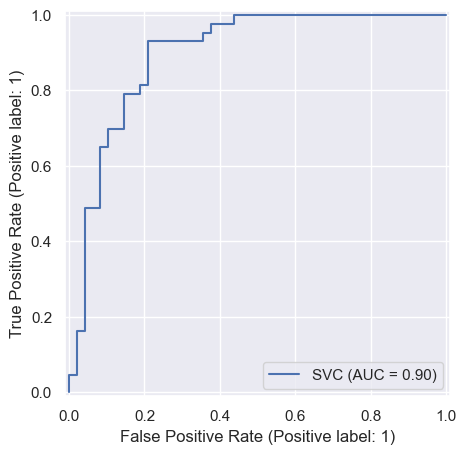

In [50]:
from sklearn.metrics import RocCurveDisplay
    
fig, ax = plt.subplots(figsize=(5,5))
svc_disp = RocCurveDisplay.from_estimator(svm_hearth_best, X_test, y_test, ax=ax)

plt.show();

Como vemos el clasificador SVC para este dataset nos dio un valor bastante alto de AUC (0.90 aprox).

----

## SVM como regresión

Como vimos en clase, SVM tambien se puede usar para realizar regresiones. Scikit-learn nos ofrece la clase [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR) que es la implementación de SVM para regresión. 

Para practicar este modelo, vamos a usar el dataset **Hitters**, el cual contiene datos de jugadores de beisbol de la liga estadounidense de 1986 y 1987. Contiene 322 observaciones con 20 datos. Este conjunto de datos se tomó de la biblioteca StatLib que se mantiene en la Universidad Carnegie Mellon. Los datos salariales fueron originalmente de Sports Illustrated, 20 de abril de 1987. Las estadísticas de 1986 y de carrera se obtuvieron de The 1987 Baseball Encyclopedia Update publicado por Collier Books, Macmillan Publishing Company, Nueva York.

Lo que queremos hacer es tener alguna regresión de los salarios de 1987 los jugadores usando como base los datos de ellos de su perfomance en 1986.

In [51]:
# Cargamos el dataset
df_hitters = pd.read_csv("./Hitters.csv")

# Como los datos de salario no están completos, descartamos a aquellos jugadores que no tienen ese dato.
df_hitters.dropna(subset="Salary", inplace=True)

# Aplico feature engineering, modificando el target por el logaritmo
df_hitters["Salary_log"] = np.log(df_hitters["Salary"])

In [52]:
df_hitters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AtBat       263 non-null    int64  
 1   Hits        263 non-null    int64  
 2   HmRun       263 non-null    int64  
 3   Runs        263 non-null    int64  
 4   RBI         263 non-null    int64  
 5   Walks       263 non-null    int64  
 6   Years       263 non-null    int64  
 7   CAtBat      263 non-null    int64  
 8   CHits       263 non-null    int64  
 9   CHmRun      263 non-null    int64  
 10  CRuns       263 non-null    int64  
 11  CRBI        263 non-null    int64  
 12  CWalks      263 non-null    int64  
 13  League      263 non-null    object 
 14  Division    263 non-null    object 
 15  PutOuts     263 non-null    int64  
 16  Assists     263 non-null    int64  
 17  Errors      263 non-null    int64  
 18  Salary      263 non-null    float64
 19  NewLeague   263 non-null    object

Tenemos todas variables numericas, menos *League*, *Division* y *NewLeague*, que vamos a obtener las variables dummy de ellas

In [53]:
df_hitters.League.value_counts()

League
A    139
N    124
Name: count, dtype: int64

In [54]:
df_hitters.Division.value_counts()

Division
W    134
E    129
Name: count, dtype: int64

In [55]:
df_hitters.NewLeague.value_counts()

NewLeague
A    141
N    122
Name: count, dtype: int64

In [56]:
df_hitters_dummies = pd.get_dummies(data=df_hitters, 
                                    columns=['League', 'Division', 'NewLeague'],
                                    drop_first=True)

In [57]:
df_hitters_dummies.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors', 'Salary', 'Salary_log', 'League_N', 'Division_W',
       'NewLeague_N'],
      dtype='object')

Obtenemos los arrays

In [58]:
X_cols = ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 
          'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 
          'Division_W', 'NewLeague_N']

X = df_hitters_dummies.loc[:, X_cols].values
# Y como variable a predecir a Salary
y = df_hitters_dummies.loc[:, 'Salary_log'].values

Separamos en el dataset de entrenamiento y testeo

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Ahora escalamos a las variables

In [60]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

Vamos a realizar otra busqueda de hiperparametros para evaluar el modelo, nada mas que ahora como metrica vamos a usar MAE, dado que estamos en un caso de regresión

In [61]:
from sklearn.svm import SVR

svm_hitters = SVR()

grid = GridSearchCV(svm_hitters,
                    [{"C": [0.01, 0.1, 1, 5, 10, 100], "kernel": ["linear"]},
                     {"C": [0.01, 0.1, 1, 5, 10, 100], "gamma": [0.1, 0.5, 1, 2, 10, 100], "kernel": ["rbf", "sigmoid"]},
                     {"C": [0.01, 0.1, 1, 5, 10, 100], "degree": [2, 3, 4, 5, 6], "kernel": ["poly"]}],
                    refit=True,
                    cv=5,
                    scoring='neg_mean_absolute_error')
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [0.01, 0.1, 1, 5, 10, 100],
                          'kernel': ['linear']},
                         {'C': [0.01, 0.1, 1, 5, 10, 100],
                          'gamma': [0.1, 0.5, 1, 2, 10, 100],
                          'kernel': ['rbf', 'sigmoid']},
                         {'C': [0.01, 0.1, 1, 5, 10, 100],
                          'degree': [2, 3, 4, 5, 6], 'kernel': ['poly']}],
             scoring='neg_mean_absolute_error')

In [62]:
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

Según esta busqueda el mejor modelo es uno con función radial.

Evaluemos este modelo con el set de testeo.

In [63]:
from sklearn.metrics import mean_absolute_error

svm_hitters_best = grid.best_estimator_

y_pred = svm_hitters_best.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

print(f"MAE de testeo fue: {mae}")

MAE de testeo fue: 0.3917577246002781


Este modelo tuvo un error de testeo de 0.39. 

Comparemos este modelo con una regresión Ridge, la cual primero hacemos una busqueda de hiperparámetros:

In [64]:
from sklearn.linear_model import Ridge

ridge_hitters = Ridge()

grid = GridSearchCV(ridge_hitters,
                    {"alpha": np.linspace(0, 20, 1000)},
                    refit=True,
                    cv=5,
                    scoring='neg_mean_absolute_error')
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([ 0.        ,  0.02002002,  0.04004004,  0.06006006,  0.08008008,
        0.1001001 ,  0.12012012,  0.14014014,  0.16016016,  0.18018018,
        0.2002002 ,  0.22022022,  0.24024024,  0.26026026,  0.28028028,
        0.3003003 ,  0.32032032,  0.34034034,  0.36036036,  0.38038038,
        0.4004004 ,  0.42042042,  0.44044044,  0.46046046,  0.48048048,
        0.5005005 ,  0.52052052,  0.5...
       19.41941942, 19.43943944, 19.45945946, 19.47947948, 19.4994995 ,
       19.51951952, 19.53953954, 19.55955956, 19.57957958, 19.5995996 ,
       19.61961962, 19.63963964, 19.65965966, 19.67967968, 19.6996997 ,
       19.71971972, 19.73973974, 19.75975976, 19.77977978, 19.7997998 ,
       19.81981982, 19.83983984, 19.85985986, 19.87987988, 19.8998999 ,
       19.91991992, 19.93993994, 19.95995996, 19.97997998, 20.        ])},
             scoring='neg_mean_absolute_error')

In [65]:
grid.best_params_

{'alpha': 15.655655655655655}

In [66]:
ridge_hitters = grid.best_estimator_

y_pred = ridge_hitters.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

print(f"MAE de testeo fue: {mae}")

MAE de testeo fue: 0.5116774668312869


Vemos que la regresión SVR que armamos mejoró un 23% con respecto a la regresión de Ridge.